In [78]:
# Install necessary requirements
# !pip install -r requirements
# Limit GPU memory growth
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [79]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import random
import numpy as np
import cv2
import joblib
import helper_module
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, DenseNet121, MobileNetV3Large, EfficientNetV2S
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, Model
from tensorflow.keras.metrics import AUC
from tensorflow.image import ssim
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity


Check if TPU is available

In [80]:
# Check if a TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU detected and initialized.")
except ValueError:
    # No TPU found, specify GPU or CPU here
    use_gpu = True  # Set this to True to use GPU or False to use CPU
    if use_gpu and tf.config.list_physical_devices("GPU"):
        strategy = tf.distribute.MirroredStrategy()  # Use GPU
        print("Using GPU for TensorFlow computations.")
    else:
        strategy = tf.distribute.get_strategy()  # Use CPU
        print("Using CPU for TensorFlow computations.")

# Now you can define and run your TensorFlow model using the selected strategy

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU for TensorFlow computations.


In [81]:
train_pairing_df =helper_module.read_csv_to_df('dataset/train.csv')
test_candidates_df = helper_module.read_csv_to_df('dataset/test_candidates.csv')

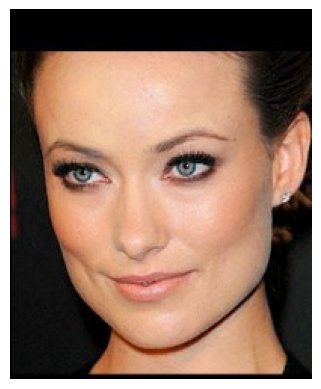

In [82]:
import matplotlib.pyplot as plt

img1 = 'dataset/train/left/abn.jpg'
im = plt.imread(img1)

plt.imshow(im)
plt.axis('off')  
plt.show()

In [83]:
train_pairing_df.head()
train_pairing_df.shape[0]


2000

1.  Load Training data and augment it
2.  Load Testing data

In [84]:
from keras.preprocessing.image import ImageDataGenerator

# Data generator for training
# Additional data augmentation may be added here if desired

train_datagen = ImageDataGenerator (
    rescale=1./255,         # Rescale pixel values to [0, 1]
    rotation_range=0,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift image width by up to 20%
    height_shift_range=0.2, # Randomly shift image height by up to 20%
    shear_range=0.2,        # Shear transformations
    zoom_range=0.0,         # Randomly zoom in on images by up to 20%
    horizontal_flip=False,   # Randomly flip images horizontally
    fill_mode='nearest',    # Fill mode for newly created pixels
)

Now Pair up the left and right images 
1. The  Data format will be  [Left,[Right1, Right2 ....]] In here the Right1 will be the similar image


In [85]:
def get_img_array(image_path, target_size=(100,100), random_transform=False):
    # Open the image using Pillow (PIL)
    img = load_img(image_path, target_size=target_size)

    img = img.resize(target_size)

    img = img_to_array(img, dtype='uint8')


    if random_transform:
        img = train_datagen.random_transform(img)

    return img

def create_train_valid_dataset(random_transform, num_right_images=20):
    # Create a list to store the dataset
    dataset = []

    # Iterate through the rows of the CSV file and load/preprocess the images
    # process each image in the left and right
    for index, row in train_pairing_df.iterrows():
        left_image = get_img_array(f"dataset/train/left/{row['left']}.jpg", random_transform=random_transform)

        # Load and preprocess similar image
        similar_image = get_img_array(f"dataset/train/right/{row['right']}.jpg", random_transform=random_transform)

        # Load and preprocess additional dissimilar images
        right_images = [similar_image]  # put similar image at index 0

        for i in range(num_right_images - 1):
            # create an array of indices excluding the current index
            indices = np.delete(np.arange(len(train_pairing_df)), index)

            # random select index
            right_idx = np.random.choice(indices)

            right_image = get_img_array(f"dataset/train/right/{train_pairing_df.iloc[right_idx]['right']}.jpg",
                                        random_transform=random_transform)
            right_images.append(right_image)

        # Create a data entry containing the left image, list of right images, and the index of the similar image
        data_entry = [left_image, right_images]
        dataset.append(data_entry)

    return dataset



def display_image_pair(image_pair):
    left_image, right_images = image_pair
    num_right_images = len(right_images)
    
    max_images_per_row = 10  # Maximum number of images to display in a single row

    num_rows = (num_right_images - 1) // max_images_per_row + 1  # Calculate the number of rows

    plt.figure(figsize=(15, 5 * num_rows))

    for i in range(num_rows):
        start_idx = i * max_images_per_row
        end_idx = min((i + 1) * max_images_per_row, num_right_images)
        
        row_right_images = right_images[start_idx:end_idx]

        plt.subplot(num_rows, max_images_per_row + 1, i * (max_images_per_row + 1) + 1)
        plt.imshow(left_image)
        plt.title("Left Image")
        plt.axis("off")

        for j, right_image in enumerate(row_right_images):
            plt.subplot(num_rows, max_images_per_row + 1, i * (max_images_per_row + 1) + j + 2)
            plt.imshow(right_image)
            plt.title(f"Right Image {start_idx + j + 1}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


In [86]:
train_valid_offical_dataset = create_train_valid_dataset(True, 20)

print(f"Total number of image pairs in dataset: {len(train_valid_offical_dataset)}")


Total number of image pairs in dataset: 2000


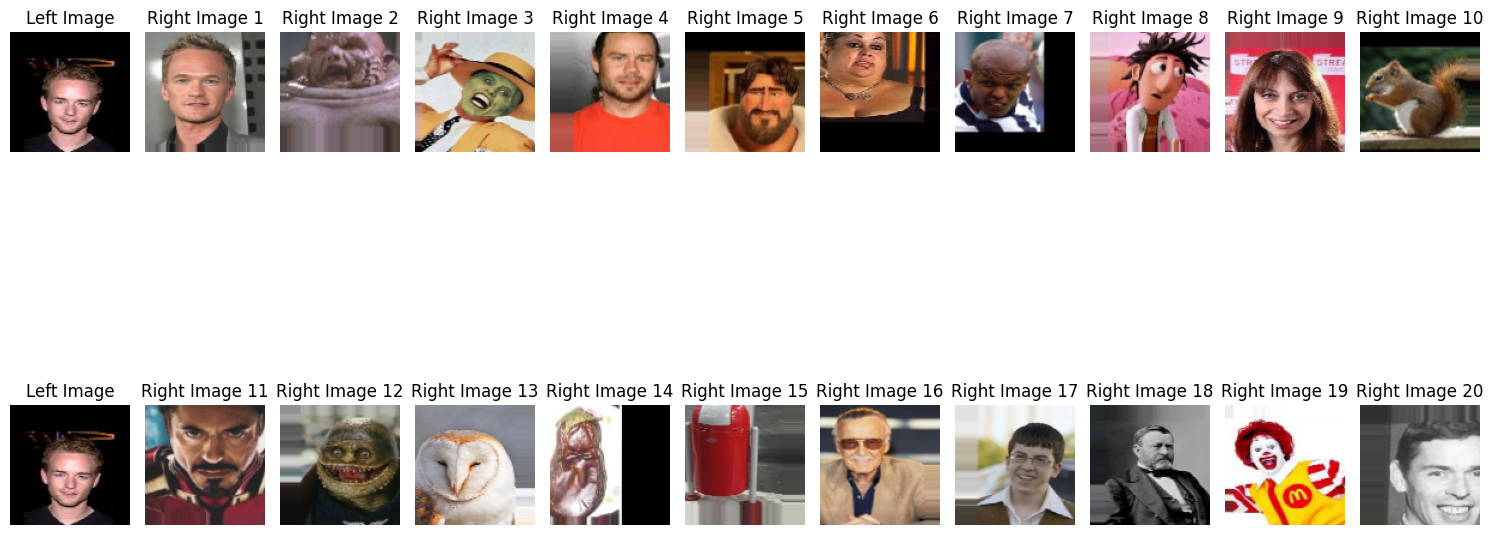

In [87]:

display_image_pair(train_valid_offical_dataset[1])

In [88]:
def extract_features(img_array, model):

    
    # Ensure the image array has the correct shape (batch_size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Depending on the pre-trained model, you might need to preprocess the image array.
    # For instance, for VGG16:
    img_array = preprocess_input(img_array)
    
    # Extract features using the model
    features = model.predict(img_array)
    
    return features

In [89]:
# Load the VGG16 model with weights pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False)
base_model.trainable = False
# If you prefer ResNet50, you can use the following line instead:
# base_model = ResNet50(weights='imagenet', include_top=False)



In [90]:
def calculate_cosine_distance(left_image, right_image, model):
    left_image = extract_features(left_image, model)
    right_image = extract_features(right_image, model)
    return cosine_similarity([left_image.flatten()], [right_image.flatten()])[0][0]

In [91]:
# Split the dataset into training and validation sets (e.g., 80% for training, 20% for validation)
train_pairs, valid_pairs = train_test_split(train_valid_offical_dataset, test_size=0.2, random_state=42)

left_image = train_pairs[30][0]
right_image = train_pairs[30][1][0]

print(f"VGG16 cosine score is {calculate_cosine_distance(left_image,right_image,base_model)}")

1/1 [==============================] - 0s 20ms/step
VGG16 cosine score is 0.49958598613739014


In [137]:


from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Subtract
from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import numpy as np

from tensorflow.keras.layers import TimeDistributed

def create_siamese_network(input_shape, num_right_inputs=20):
    """Create a Siamese network with VGG16 as the base model."""
    
    # Load VGG16 as base model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the VGG16 model
    
    # Flatten and Dense layers to transform features
    flatten = Flatten()(base_model.output)
    dense = Dense(256, activation='relu')(flatten)
    embedding_model = Model(inputs=base_model.input, outputs=dense)
    
    # Define the two inputs (one for each image)
    
    input_right_list = tf.keras.layers.Input(shape=(num_right_inputs,) + input_shape, name="right_input")

    input_left = tf.keras.layers.Input(shape=input_shape, name="left_input")
    
    # Process the right input list using the embedding model
    processed_right_list = TimeDistributed(embedding_model)(input_right_list)

    # Process the left input using the embedding model
    processed_left = embedding_model(input_left)
    
    
    # Compute cosine similarity between the two feature vectors
    cosine_similarity = Dot(axes=[1, 2], normalize=True)([processed_left, processed_right_list])
    
    # Create the Siamese model
    siamese_network = Model(inputs=[input_left, input_right_list], outputs=cosine_similarity)
    
    return siamese_network

# Define the Siamese network with a sample input shape
input_shape = (100, 100, 3)
siamese_network = create_siamese_network(input_shape)
siamese_network.summary()



Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 20, 100, 10  0           []                               
                                0, 3)]                                                            
                                                                                                  
 model_19 (Functional)          (None, 256)          15894592    ['left_input[0][0]']             
                                                                                           

In [138]:
# Compile the Siamese network model
siamese_network.compile(optimizer=Adam(learning_rate=0.1), 
                        loss='mean_squared_error', 
                        metrics=['accuracy'])

In [139]:
from sklearn.model_selection import train_test_split

# Split the dataset into raining and validation sets
train_pairs, valid_pairs = train_test_split(train_valid_offical_dataset, test_size=0.2, random_state=42)

def prepare_data(pair_list, batch_size=32, num_right_images=20):
    while True:
        left_images = []
        right_images = []
        labels = []

        # Shuffle the pairs for each epoch
        random.shuffle(pair_list)

        for pair in pair_list:
            left_image, right_images_list = pair[0], pair[1]

            # Create labels as a list of similarity scores (1.0 for the similar image, 0.0 for dissimilar images)
            label = [1] + [0] * (num_right_images - 1)

            left_images.append(left_image)  # Add the left image to the left_images list
            right_images.append(right_images_list[:num_right_images])
            labels.append(label)

            if len(left_images) >= batch_size:
                yield [np.array(left_images), np.array(right_images)], np.array(labels)
                left_images = []
                right_images = []
                labels = []

        # Yield the remaining data in the last batch
        if len(left_images) > 0:
            yield [np.array(left_images), np.array(right_images)], np.array(labels)




In [140]:
num_epochs = 10  # Adjust the number of epochs as needed
batch_size = 20  # Adjust the batch size as needed
number_of_right_images = 20
unfreeze_layer_number=0

# Example usage:
train_generator = prepare_data(train_pairs,batch_size=batch_size,num_right_images=number_of_right_images)
valid_generator = prepare_data(valid_pairs,batch_size=batch_size,num_right_images=number_of_right_images)

# Fetch a batch from the generator
batch = next(train_generator)
# Unpack the batch into inputs and labels
val_batch = next(valid_generator)
inputs,labels = batch
inputs_val,labels_val = val_batch
# Print the shape of the left input
print(len(batch))
print(f"Left Input shape: {inputs[0].shape}")
print(f"Right Input shape: {inputs[1].shape}")
print(f"Labels shape: {labels.shape}")



2
Left Input shape: (20, 100, 100, 3)
Right Input shape: (20, 20, 100, 100, 3)
Labels shape: (20, 20)


In [141]:
# model training

num_epochs = 10
batch_size = 10


# Train the siamese network
history = siamese_network.fit(
        x=train_generator,
        steps_per_epoch=len(train_pairs) // batch_size,
        validation_data=valid_generator,
        validation_steps=len(valid_pairs) // batch_size,
        epochs=num_epochs,
        batch_size=batch_size
    )

Epoch 1/10
160/160 [==============================] - 57s 346ms/step - loss: 0.0964 - accuracy: 0.2566 - val_loss: 0.0557 - val_accuracy: 0.2000
Epoch 2/10
160/160 [==============================] - 55s 342ms/step - loss: 0.0350 - accuracy: 0.5472 - val_loss: 0.0542 - val_accuracy: 0.2575
Epoch 3/10
160/160 [==============================] - 55s 344ms/step - loss: 0.0278 - accuracy: 0.7309 - val_loss: 0.0551 - val_accuracy: 0.3975
Epoch 4/10
160/160 [==============================] - 55s 342ms/step - loss: 0.0270 - accuracy: 0.7816 - val_loss: 0.0540 - val_accuracy: 0.3738
Epoch 5/10
160/160 [==============================] - 55s 344ms/step - loss: 0.0252 - accuracy: 0.8156 - val_loss: 0.0545 - val_accuracy: 0.4288
Epoch 6/10
160/160 [==============================] - 55s 342ms/step - loss: 0.0279 - accuracy: 0.7387 - val_loss: 0.0574 - val_accuracy: 0.2688
Epoch 7/10
160/160 [==============================] - 55s 343ms/step - loss: 0.0252 - accuracy: 0.8253 - val_loss: 0.0568 - val_ac

In [142]:
def get_test_result(model, test_candidates_df):
    results = []
    
    for _, row in test_candidates_df.iterrows():
        left_image = get_img_array(f"dataset/test/left/{row['left']}.jpg")
        right_images = [get_img_array(f"dataset/test/right/{row[f'c{i}']}.jpg") for i in range(20)]
        
        # Convert to NumPy arrays
        left_image = np.array([left_image])
        right_images = np.array([right_images])
        
        # Run prediction
        similarity_scores = model.predict([left_image, right_images], verbose=0)[0]
        
        # Prepare row for output
        new_row = {'left': row['left']}
        for i, score in enumerate(similarity_scores):
            new_row[f"c{i}"] = score
        results.append(new_row)
    
    # Convert results to DataFrame and save to CSV
    output_df = pd.DataFrame(results)
    output_df.to_csv('submission.csv', index=False)
print("Results saved to submission.csv")



Results saved to submission.csv


In [143]:
def show_test_case(model,row_number=5):
    for index, row in test_candidates_df.iterrows():
        if index >= row_number:
            break

        print(f"Row {index}")
        max_similarity_score = -1  # Initialize max_similarity_score to a very low value
        best_left_img = None
        best_right_img = None

        for column, value in row.items():
            print(f"  Column {column}: {value}")
            if column == 'left':
                test_img_left = get_img_array(f"dataset/test/left/{value}.jpg")
            else:
                test_img_right = get_img_array(f"dataset/test/right/{value}.jpg")
                left_img_array = np.expand_dims(test_img_left, axis=0)
                right_img_array = np.expand_dims(test_img_right, axis=0)

                # Calculate the similarity score
                similarity_score = model.predict([left_img_array, right_img_array],verbose=0)
                print(similarity_score)
                if similarity_score > max_similarity_score:
                    max_similarity_score = similarity_score
                    best_left_img = test_img_left
                    best_right_img = test_img_right
        print(f"Highest Similarity Score: {max_similarity_score}")

In [151]:
import math

def show_test_case(model, test_candidates_df, row_number=5):
    for index, row in test_candidates_df.iterrows():
        if index >= row_number:
            break

        print(f"Row {index}")

        left_image = None
        right_images = []

        for column, value in row.items():
            print(f"  Column {column}: {value}")
            if column == 'left':
                left_image = get_img_array(f"dataset/test/left/{value}.jpg")
            else:
                test_img_right = get_img_array(f"dataset/test/right/{value}.jpg")
                right_images.append(test_img_right)

        # Convert to NumPy arrays
        left_image = np.array([left_image])
        right_images = np.array([right_images])
        # Calculate the similarity score
        similarity_score = model.predict([left_image, right_images],verbose=0)

        # Run prediction
        try:
            similarity_scores = model.predict([left_image, right_images], verbose=0)[0]
            print("Similarity Scores:", similarity_scores)
        except Exception as e:
            print("An error occurred during prediction:", e)


       


In [152]:
show_test_case(siamese_network,test_candidates_df,row_number=20)

Row 0
  Column left: abm
  Column c0: kyr
  Column c1: qqo
  Column c2: xpv
  Column c3: tnd
  Column c4: xal
  Column c5: pvr
  Column c6: nsb
  Column c7: yzv
  Column c8: ahb
  Column c9: mlm
  Column c10: drb
  Column c11: vqu
  Column c12: vzr
  Column c13: kxe
  Column c14: mdq
  Column c15: oai
  Column c16: nmm
  Column c17: yzu
  Column c18: ihk
  Column c19: zwv
Similarity Scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Row 1
  Column left: aci
  Column c0: jzn
  Column c1: hxw
  Column c2: iaj
  Column c3: edq
  Column c4: huu
  Column c5: huk
  Column c6: owo
  Column c7: ntd
  Column c8: uhk
  Column c9: ojv
  Column c10: mhg
  Column c11: exb
  Column c12: pny
  Column c13: kbo
  Column c14: tdb
  Column c15: sok
  Column c16: zsq
  Column c17: yfg
  Column c18: iqx
  Column c19: jnj
Similarity Scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Row 2
  Column left: acn
  Column c0: ksm
  Column c1: tyj
  Column c2: hhy
  Column c3: